# ABC calibration of $I_\text{CaL}$ in Courtemanche model to unified dataset.

In [6]:
import os, tempfile
import logging
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [7]:
from ionchannelABC import theoretical_population_size
from ionchannelABC import IonChannelDistance, EfficientMultivariateNormalTransition, IonChannelAcceptor
from ionchannelABC.experiment import setup
from ionchannelABC.visualization import plot_sim_results, plot_kde_matrix_custom
import myokit

In [8]:
from pyabc import Distribution, RV, History, ABCSMC
from pyabc.epsilon import MedianEpsilon
from pyabc.sampler import MulticoreEvalParallelSampler, SingleCoreSampler
from pyabc.populationstrategy import ConstantPopulationSize

## Initial set-up

Load experiments for unified dataset:
 - Steady-state activation [Li1997]
 - Activation time constant [Li1997]
 - Steady-state inactivation [Li1997]
 - Inactivation time constant [Sun1997]
 - Recovery time constant [Li1997]

In [1]:
from experiments.ical_li import (li_act_and_tau,
                                 li_inact_1000,
                                 li_inact_kin_80,
                                 li_recov)

INFO:myokit:Loading Myokit version 1.28.3


In [2]:
modelfile = 'models/courtemanche_ical.mmt'

Plot steady-state and tau functions

In [9]:
from ionchannelABC.visualization import plot_variables

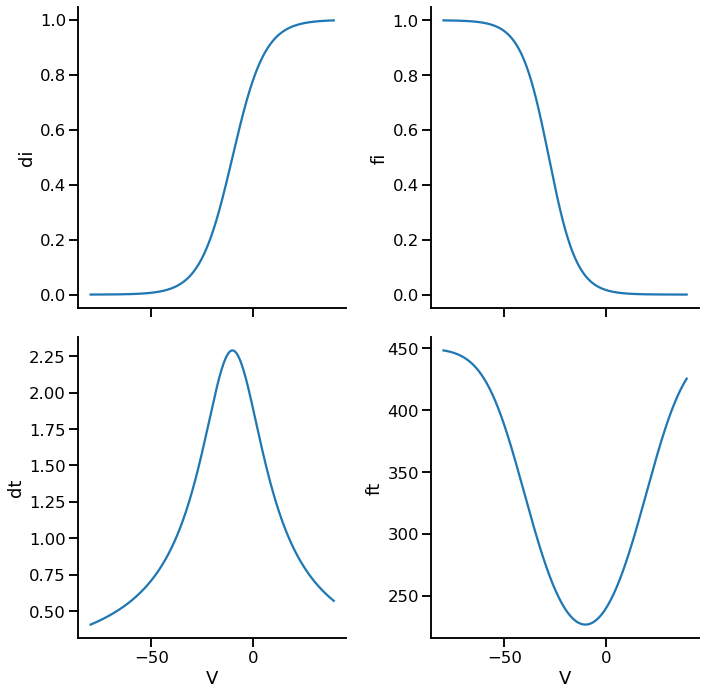

In [10]:
sns.set_context('talk')

V = np.arange(-80, 40, 0.01)

cou_par_map = {'di': 'ical.d_inf',
            'fi': 'ical.f_inf',
            'dt': 'ical.tau_d',
            'ft': 'ical.tau_f'}

f, ax = plot_variables(V, cou_par_map, 'models/courtemanche_ical.mmt', figshape=(2,2))

# Activation gate ($d$) calibration

Combine model and experiments to produce:
 - observations dataframe
 - model function to run experiments and return traces
 - summary statistics function to accept traces

In [11]:
observations, model, summary_statistics = setup(modelfile,
                                                li_act_and_tau)

In [12]:
assert len(observations)==len(summary_statistics(model({})))

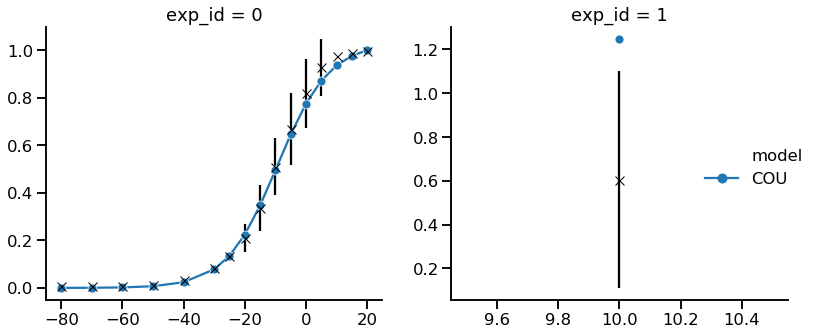

In [13]:
g = plot_sim_results(modelfile,
                     li_act_and_tau)

### Set up prior ranges for each parameter in the model.

See the modelfile for further information on specific parameters. Prepending `log_' has the effect of setting the parameter in log space.

In [14]:
limits = {'ical.p1': (-100, 100),
          'ical.p2': (0, 50),
          'log_ical.p3': (-7, 3),
          'ical.p4': (-100, 100),
          'ical.p5': (0, 50)}
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

In [15]:
# Test this works correctly with set-up functions
assert len(observations) == len(summary_statistics(model(prior.rvs())))

### Run ABC calibration

In [16]:
db_path = ("sqlite:///" + os.path.join(tempfile.gettempdir(), "courtemanche_ical_dgate_unified.db"))

In [17]:
logging.basicConfig()
abc_logger = logging.getLogger('ABC')
abc_logger.setLevel(logging.DEBUG)
eps_logger = logging.getLogger('Epsilon')
eps_logger.setLevel(logging.DEBUG)

In [18]:
pop_size = theoretical_population_size(2, len(limits))
print("Theoretical minimum population size is {} particles".format(pop_size))

Theoretical minimum population size is 32 particles


In [19]:
abc = ABCSMC(models=model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 exp_id=list(observations.exp_id),
                 variance=list(observations.variance),
                 delta=0.05),
             population_size=ConstantPopulationSize(2000),
             summary_statistics=summary_statistics,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(initial_epsilon=100),
             sampler=MulticoreEvalParallelSampler(n_procs=16),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {'0': 1.2287454676498424, '1': 1.2287454676498424, '2': 1.2287454676498424, '3': 1.2287454676498424, '4': 1.2287454676498424, '5': 1.2287454676498424, '6': 1.2287454676498424, '7': 1.0293830767146164, '8': 0.6283247351374927, '9': 0.5133263088125923, '10': 0.4040167399213943, '11': 0.41888315675832816, '12': 0.5146915383573082, '13': 1.2287454676498424, '14': 1.2287454676498424, '15': 1.2287454676498424, '16': 1.2039197677998432}
DEBUG:Epsilon:init quantile_epsilon initial_epsilon=100, quantile_multiplier=1


In [20]:
obs = observations.to_dict()['y']
obs = {str(k): v for k, v in obs.items()}

In [21]:
abc_id = abc.new(db_path, obs)

INFO:History:Start <ABCSMC(id=1, start_time=2019-10-18 11:23:07.136757, end_time=None)>


In [22]:
history = abc.run(minimum_epsilon=0., max_nr_populations=100, min_acceptance_rate=0.01)

INFO:ABC:t:0 eps:100
DEBUG:ABC:now submitting population 0
DEBUG:ABC:population 0 done
DEBUG:ABC:
total nr simulations up to t =0 is 2718
DEBUG:Epsilon:new eps, t=1, eps=2.3341083502077473
INFO:ABC:t:1 eps:2.3341083502077473
DEBUG:ABC:now submitting population 1
DEBUG:ABC:population 1 done
DEBUG:ABC:
total nr simulations up to t =1 is 6798
DEBUG:Epsilon:new eps, t=2, eps=1.4388485321914328
INFO:ABC:t:2 eps:1.4388485321914328
DEBUG:ABC:now submitting population 2
DEBUG:ABC:population 2 done
DEBUG:ABC:
total nr simulations up to t =2 is 11092
DEBUG:Epsilon:new eps, t=3, eps=1.292902313705072
INFO:ABC:t:3 eps:1.292902313705072
DEBUG:ABC:now submitting population 3
DEBUG:ABC:population 3 done
DEBUG:ABC:
total nr simulations up to t =3 is 16188
DEBUG:Epsilon:new eps, t=4, eps=1.1751087332605836
INFO:ABC:t:4 eps:1.1751087332605836
DEBUG:ABC:now submitting population 4
DEBUG:ABC:population 4 done
DEBUG:ABC:
total nr simulations up to t =4 is 21841
DEBUG:Epsilon:new eps, t=5, eps=0.95105544870

### Analysis of results

In [19]:
history = History('sqlite:///results/courtemanche/ical/unified/courtemanche_ical_dgate_unified.db')

In [20]:
df, w = history.get_distribution(m=0)

In [21]:
df.describe()

name,ical.p1,ical.p2,ical.p4,ical.p5,log_ical.p3
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,-55.456006,12.188599,10.311932,7.492075,-1.450409
std,20.599434,10.602261,0.204818,0.109751,0.227195
min,-99.985450,0.170767,9.520564,7.218237,-1.869195
25%,-71.157241,4.119229,10.223532,7.415439,-1.628989
50%,-53.611204,9.019055,10.351252,7.484404,-1.483651
75%,-38.379680,17.492310,10.453144,7.551744,-1.289556
max,24.102362,49.748571,10.988258,8.076213,-0.652669


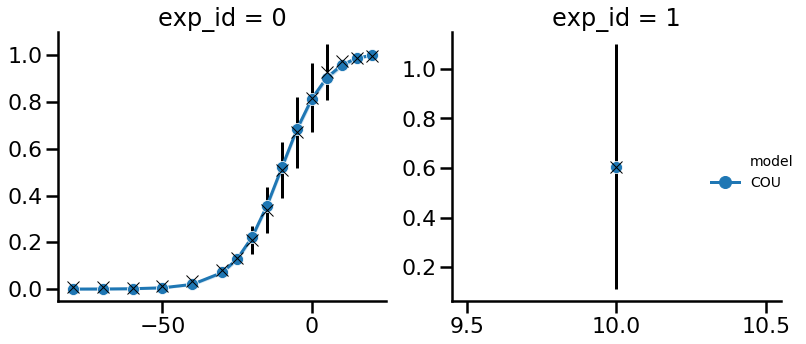

In [22]:
sns.set_context('poster')

mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

g = plot_sim_results(modelfile,
                     li_act_and_tau,
                     df=df, w=w)

plt.tight_layout()

In [23]:
m,_,_ = myokit.load(modelfile)

In [24]:
originals = {}
for name in limits.keys():
    if name.startswith("log"):
        name_ = name[4:]
    else:
        name_ = name
    val = m.value(name_)
    if name.startswith("log"):
        val_ = np.log10(val)
    else:
        val_ = val
    originals[name] = val_

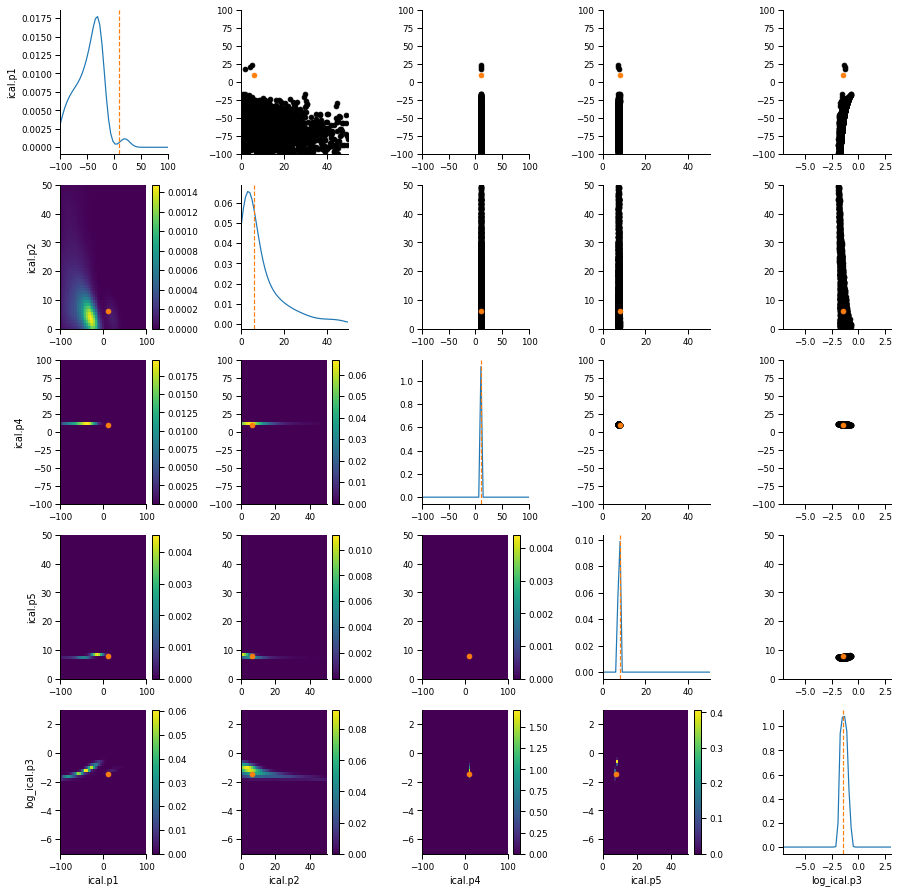

In [25]:
sns.set_context('paper')
g = plot_kde_matrix_custom(df, w, limits=limits, refval=originals)
plt.tight_layout()

In [26]:
import pandas as pd
N = 100
cou_par_samples = df.sample(n=N, weights=w, replace=True)
cou_par_samples = cou_par_samples.set_index([pd.Index(range(N))])
cou_par_samples = cou_par_samples.to_dict(orient='records')

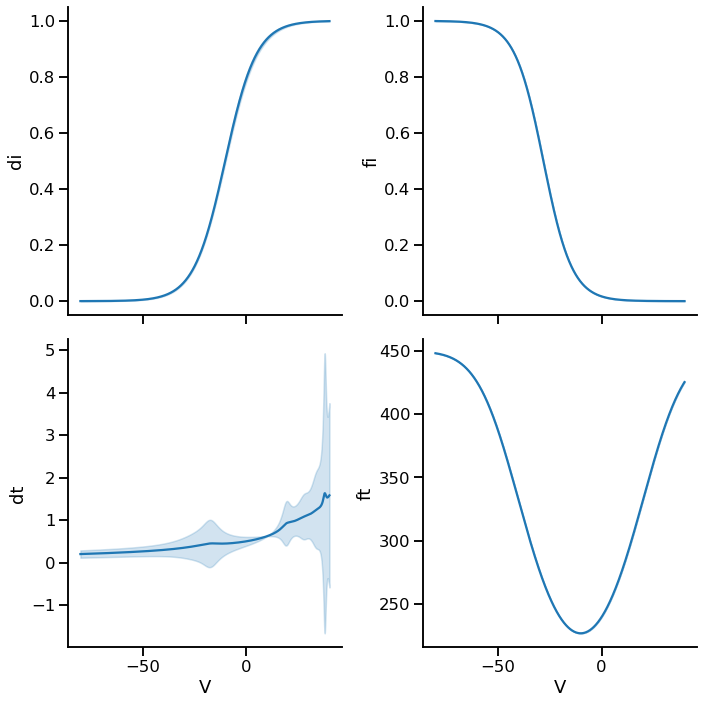

In [28]:
sns.set_context('talk')
mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14
V = np.arange(-80, 40, 0.01)

f, ax = plot_variables(V, cou_par_map, 
                       'models/courtemanche_ical.mmt', 
                       [cou_par_samples],
                       figshape=(2,2))

# Voltage-dependent inactivation gate ($f$) calibration

In [29]:
observations, model, summary_statistics = setup(modelfile,
                                                li_inact_1000,
                                                li_inact_kin_80,
                                                li_recov)

In [30]:
assert len(observations)==len(summary_statistics(model({})))

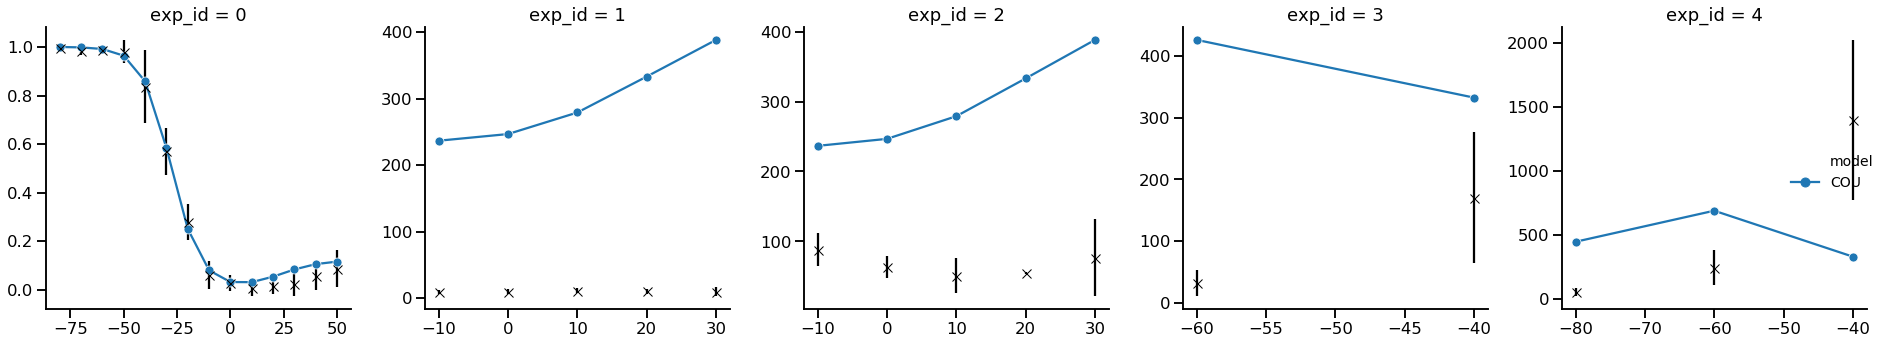

In [31]:
g = plot_sim_results(modelfile,
                     li_inact_1000,
                     li_inact_kin_80,
                     li_recov)

In [35]:
limits = {'log_ical.q1': (0, 3),
          'log_ical.q2': (-2, 3),
          'log_ical.q3': (-4, 0),
          'ical.q4': (-100, 100),
          'log_ical.q5': (-4, 0),
          'ical.q6': (-100, 100),
          'ical.q7': (0, 50)}
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

In [33]:
# Test this works correctly with set-up functions
assert len(observations) == len(summary_statistics(model(prior.rvs())))

### Run ABC calibration

In [39]:
db_path = ("sqlite:///" + os.path.join(tempfile.gettempdir(), "courtemanche_ical_fgate_unified.db"))

In [40]:
logging.basicConfig()
abc_logger = logging.getLogger('ABC')
abc_logger.setLevel(logging.DEBUG)
eps_logger = logging.getLogger('Epsilon')
eps_logger.setLevel(logging.DEBUG)

In [36]:
pop_size = theoretical_population_size(2, len(limits))
print("Theoretical minimum population size is {} particles".format(pop_size))

Theoretical minimum population size is 128 particles


In [42]:
abc = ABCSMC(models=model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 exp_id=list(observations.exp_id),
                 variance=list(observations.variance),
                 delta=0.05),
             population_size=ConstantPopulationSize(2000),
             summary_statistics=summary_statistics,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(initial_epsilon=100),
             sampler=MulticoreEvalParallelSampler(n_procs=16),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {'0': 0.9837148289810969, '1': 0.9837148289810969, '2': 0.9837148289810969, '3': 0.9837148289810969, '4': 0.32559180605160337, '5': 0.5055241199222263, '6': 0.6753486289586008, '7': 0.8392681990941823, '8': 0.9837148289810969, '9': 0.9837148289810969, '10': 0.9837148289810969, '11': 0.9196236649649017, '12': 0.8392681990941823, '13': 0.630982660632852, '14': 0.4608478344438249, '15': 0.41845619672000584, '16': 0.3688677609080382, '17': 0.4191992497796025, '18': 0.21952975590454926, '19': 0.5102122707484876, '20': 0.7659862673065289, '21': 0.4791367008919786, '22': 2.7544015211470714, '23': 0.21885528270246787, '24': 2.7490646934055034, '25': 0.5560031468540616, '26': 4.590669201911785, '27': 2.3543059353664946, '28': 0.5128531003233775}
DEBUG:Epsilon:init quantile_epsilon initial_epsilon=100, quantile_multiplier=1


In [43]:
obs = observations.to_dict()['y']
obs = {str(k): v for k, v in obs.items()}

In [44]:
abc_id = abc.new(db_path, obs)

INFO:History:Start <ABCSMC(id=1, start_time=2019-10-18 13:00:18.672140, end_time=None)>


In [ ]:
history = abc.run(minimum_epsilon=0., max_nr_populations=100, min_acceptance_rate=0.01)

INFO:ABC:t:0 eps:100
DEBUG:ABC:now submitting population 0
DEBUG:ABC:population 0 done
DEBUG:ABC:
total nr simulations up to t =0 is 13529
DEBUG:Epsilon:new eps, t=1, eps=12.23621431947022
INFO:ABC:t:1 eps:12.23621431947022
DEBUG:ABC:now submitting population 1
DEBUG:ABC:population 1 done
DEBUG:ABC:
total nr simulations up to t =1 is 18820
DEBUG:Epsilon:new eps, t=2, eps=2.722928347980856
INFO:ABC:t:2 eps:2.722928347980856
DEBUG:ABC:now submitting population 2
DEBUG:ABC:population 2 done
DEBUG:ABC:
total nr simulations up to t =2 is 24203
DEBUG:Epsilon:new eps, t=3, eps=2.142896999846905
INFO:ABC:t:3 eps:2.142896999846905
DEBUG:ABC:now submitting population 3
DEBUG:ABC:population 3 done
DEBUG:ABC:
total nr simulations up to t =3 is 30496
DEBUG:Epsilon:new eps, t=4, eps=1.9438174194207405
INFO:ABC:t:4 eps:1.9438174194207405
DEBUG:ABC:now submitting population 4
DEBUG:ABC:population 4 done
DEBUG:ABC:
total nr simulations up to t =4 is 37582
DEBUG:Epsilon:new eps, t=5, eps=1.8399611386008

### Analysis of results

In [37]:
history = History('sqlite:///results/courtemanche/ical/unified/courtemanche_ical_fgate_unified.db')

In [38]:
df, w = history.get_distribution(m=0)

In [39]:
df.describe()

name,ical.q4,ical.q6,ical.q7,log_ical.q1,log_ical.q2,log_ical.q3,log_ical.q5
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,2.080703,31.955913,9.917283,0.710021,0.226367,-0.953780,-0.739305
std,2.177890,4.378835,2.171238,0.394951,0.504092,0.115154,0.392909
min,-2.973223,21.509410,4.934702,0.000303,-0.988494,-1.272651,-1.516609
25%,0.595276,28.445285,8.118411,0.375278,-0.150826,-1.035714,-1.069484
50%,1.647715,31.580719,9.904920,0.709021,0.229111,-0.934002,-0.738240
75%,2.920362,35.021990,11.572423,1.034219,0.611384,-0.871033,-0.415394
max,9.969429,46.398248,17.032993,1.500817,2.004804,-0.700588,-0.001114


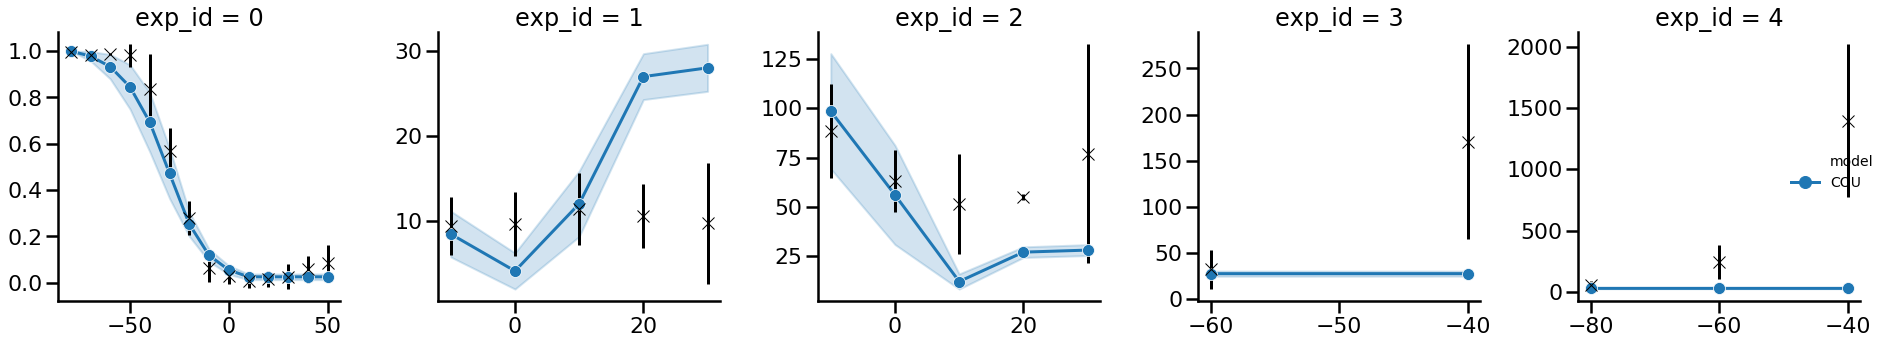

In [41]:
sns.set_context('poster')

mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

g = plot_sim_results(modelfile,
                     li_inact_1000,
                     li_inact_kin_80,
                     li_recov,
                     df=df, w=w)

plt.tight_layout()

In [42]:
m,_,_ = myokit.load(modelfile)

In [43]:
originals = {}
for name in limits.keys():
    if name.startswith("log"):
        name_ = name[4:]
    else:
        name_ = name
    val = m.value(name_)
    if name.startswith("log"):
        val_ = np.log10(val)
    else:
        val_ = val
    originals[name] = val_

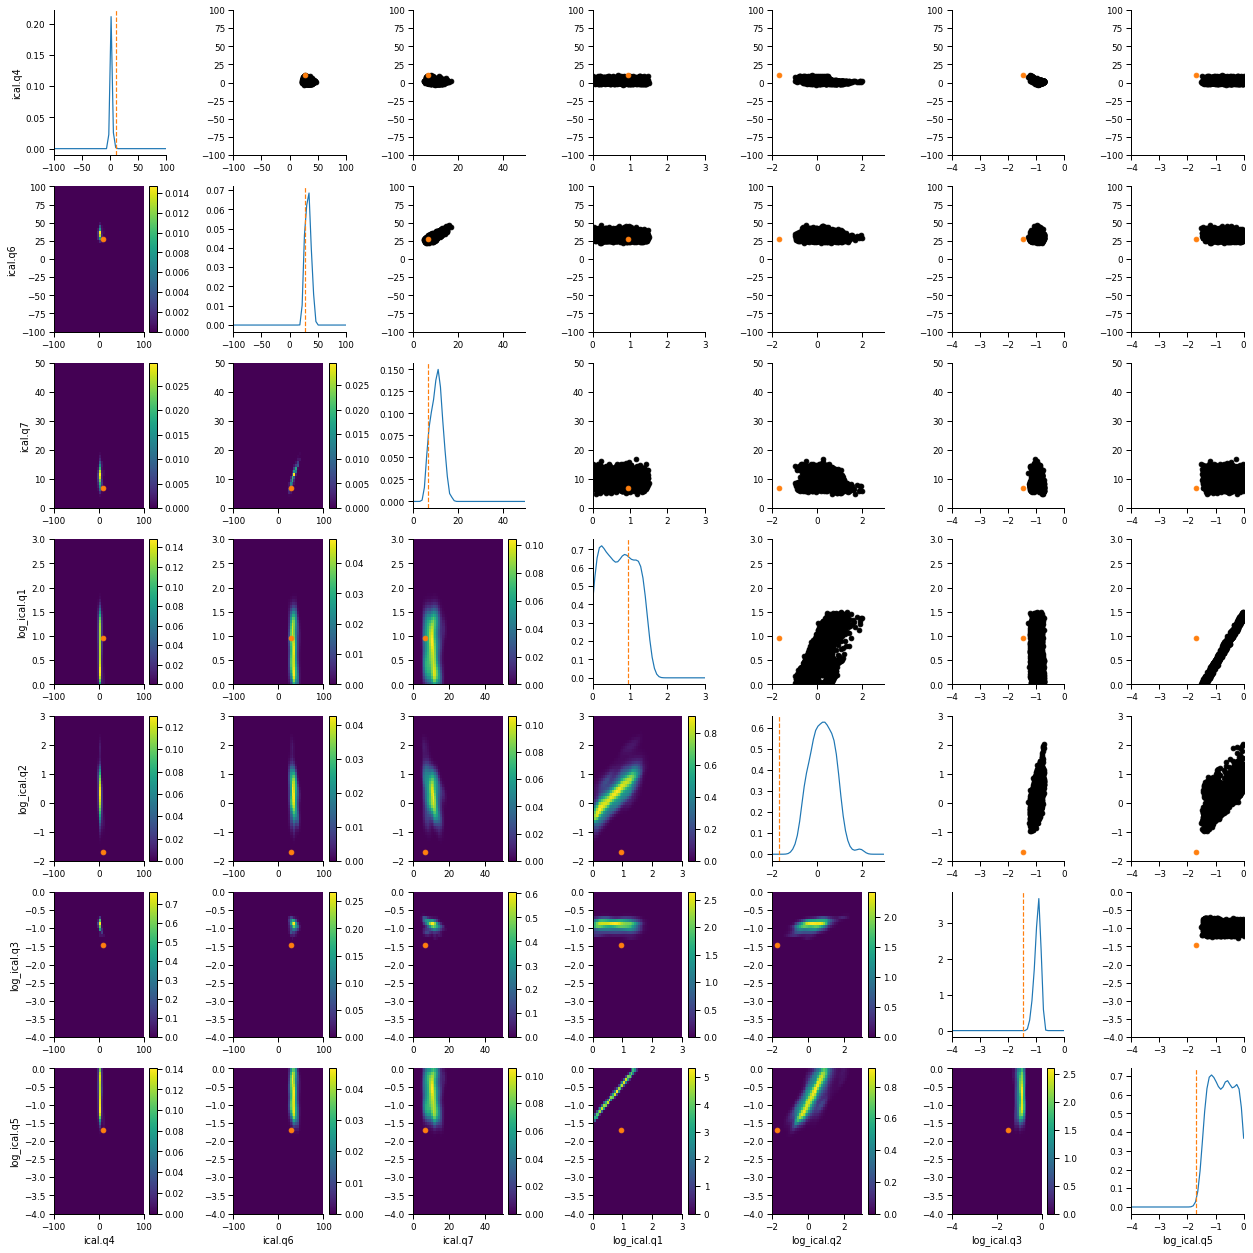

In [44]:
sns.set_context('paper')
g = plot_kde_matrix_custom(df, w, limits=limits, refval=originals)
plt.tight_layout()

In [45]:
N = 100
cou_par_samples = df.sample(n=N, weights=w, replace=True)
cou_par_samples = cou_par_samples.set_index([pd.Index(range(N))])
cou_par_samples = cou_par_samples.to_dict(orient='records')

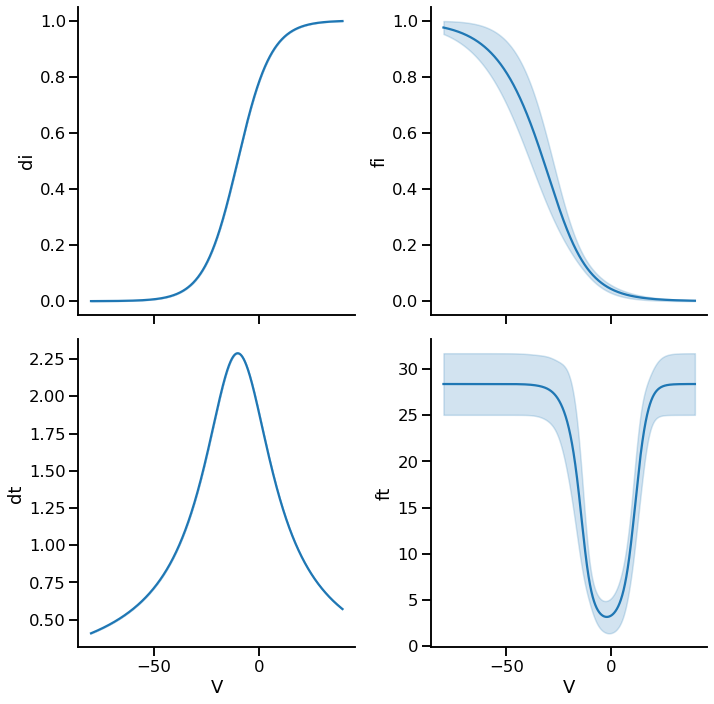

In [46]:
sns.set_context('talk')
mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14
V = np.arange(-80, 40, 0.01)

f, ax = plot_variables(V, cou_par_map, 
                       'models/courtemanche_ical.mmt', 
                       [cou_par_samples],
                       figshape=(2,2))